In [1]:
import os

import numpy as np
import pandas as pd
import PIL.Image
from IPython.display import Image
import cv2
from keras.utils import np_utils

Using TensorFlow backend.


# init stuff

In [2]:
# os.chdir("../")
# os.getcwd()
# path_to_data="training_data/"
# path_to_model="model_data/"
# path_to_forms = "test/example_forms/unihack/"

from google.colab import drive
drive.mount('/content/drive')
path_to_data="/content/drive/My Drive/UniHack/Notebooks and data/"
path_to_model = "/content/drive/My Drive/UniHack/Notebooks and data/model/"
path_to_forms = "/content/drive/My Drive/UniHack/Notebooks and data/forms/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
TYPE="numbers"
# TYPE="letters"

def is_the_type(x):
#     return ord("A") <= x <= ord("Z")
    return ord("0") <= x <= ord("9")


with open(path_to_data + "emnist-balanced-mapping.txt") as f:
    s = f.read()[:-1] # remove last char \n
a = [l.split(" ") for l in s.split("\n")]
original_mapper = {int(l[0]): chr(int(l[1])) for l in a if is_the_type(int(l[1]))}



num_classes = len(original_mapper)

to_substract = min(original_mapper.keys())

res_mapper = {k - to_substract: v for k,v in original_mapper.items()}



def filter_letters(df):
    return df[df.iloc[:,0].apply(lambda x: x in original_mapper.keys())]

print(original_mapper)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}



# Model training

## load dataset

In [4]:
train_db = pd.read_csv(path_to_data + "emnist-balanced-enriched-train.csv", header=None)

KeyboardInterrupt: ignored

In [0]:
train_db = filter_letters(train_db)
train_db.loc[:,0] = train_db[0] -  to_substract

First, you might want to enrich the dataset - in separate notebook.

## training itself model

In [0]:

y_train = train_db.iloc[:,0] 
y_train = np_utils.to_categorical(y_train, num_classes)


In [16]:
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model

y_train = train_db.iloc[:,0]
y_train = np_utils.to_categorical(y_train, num_classes)
print ("y_train:", y_train.shape)

x_train = train_db.iloc[:,1:]
x_train = x_train.astype('float32')
x_train /= 255
print ("x_train:",x_train.shape)

inp = Input(shape=(784,))
hidden_1 = Dense(1024, activation='relu')(inp)
dropout_1 = Dropout(0.4)(hidden_1)
out = Dense(num_classes, activation='softmax')(hidden_1)
model = Model(input=inp, output=out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

model.fit(x_train, y_train, # Train the model using the training set...
          batch_size=512, nb_epoch=10,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation


y_train: (48000, 10)
x_train: (48000, 784)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 43200 samples, validate on 4800 samples
Epoch 1/10
43200/43200 [==============================] - 5s 105us/step - loss: 0.6441 - accuracy: 0.8101 - val_loss: 0.6145 - val_accuracy: 0.8304
Epoch 2/10
43200/43200 [==============================] - 4s 103us/step - loss: 0.2823 - accuracy: 0.9234 - val_loss: 0.3687 - val_accuracy: 0.9008
Epoch 3/10
43200/43200 [==============================] - 4s 102us/step - loss: 0.1737 - accuracy: 0.9546 - val_loss: 0.2738 - val_accuracy: 0.9290
Epoch 4/10
43200/43200 [==============================] - 4s 103us/step - loss: 0.1228 - accuracy: 0.9688 - val_loss: 0.2225 - val_accuracy: 0.9394
Epoch 5/10
43200/43200 [==============================] - 5s 105us/step - loss: 0.0926 - accuracy: 0.9772 - val_loss: 0.1882 - val_accuracy: 0.9510
Epoch 6/10
43200/43200 [==============================] - 4s 104us/step - loss: 0.0726 - accuracy: 0.9825 - val_loss: 0.1767 - val_accuracy: 0.9515
Epoch 7/10
43200/43200 [==============================] - 4s 10

## model save

In [30]:
import json
 
# serialize model to JSON
model_json = model.to_json()
with open(f"{path_to_model}model_{TYPE}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{path_to_model}model_{TYPE}.h5")

 
with open(f"{path_to_model}model_{TYPE}_mapping.json", "w") as json_file:
    json.dump(res_mapper, json_file)
    

print("Saved model to disk")


Saved model to disk


# Testing the model

## model load

In [4]:
from keras.models import model_from_json

test_db  = pd.read_csv(path_to_data + "emnist-balanced-enriched-test.csv")
test_db = filter_letters(test_db)
y_test = test_db.iloc[:,0]
y_test = np_utils.to_categorical(y_test, num_classes)
test_db.iloc[:,0] = test_db.iloc[:, 0] -  to_substract

x_test = test_db.iloc[:,1:]
x_test = x_test.astype('float32')
x_test /= 255


# load json and create model
json_file = open(path_to_model + f'model_{TYPE}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(path_to_model + f'model_{TYPE}.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy


scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Loaded model from disk
accuracy: 96.91%


## Display data from dataset

In [0]:
def show_letter_from_db(img):
    img = img.astype('uint8')
    img = img.reshape((28,28))
    img = img.transpose()
    img = cv2.bitwise_not(img)
    
    display(PIL.Image.fromarray(img))
    return img

In [0]:
def revert_showing(img):
    img = cv2.bitwise_not(img)
    img = img.transpose()
    img = img.ravel()
    img = img.astype('int64') 
    return img

In [0]:
def display_char(i):
    label = test_db.iloc[i].values[0]
    char = res_mapper.get(label)
    img = test_db.iloc[i].values[1:]
    
    print("=============")
    show_letter_from_db(img)
    print(f"label: {char}")
    
    pred = model.predict(np.array([img]))
    pred_val = res_mapper.get(pred[0].argmax())
    print(f"Prediction: {pred_val}")


In [8]:
for i in range (15):
    display_char(i)

label: 9
Prediction: 9


label: 3
Prediction: 3


label: 7
Prediction: 7


label: 2
Prediction: 2


label: 6
Prediction: 6


label: 8
Prediction: 8


label: 4
Prediction: 4


label: 1
Prediction: 1


label: 3
Prediction: 3


label: 5
Prediction: 5


label: 1
Prediction: 1


label: 6
Prediction: 6


label: 0
Prediction: 0


label: 2
Prediction: 2


label: 3
Prediction: 3


## data from our forms

In [0]:
import sys

In [0]:

sys.path += ["/content/drive/My Drive/UniHack/fast-form/"]

In [11]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/My Drive/UniHack/fast-form/']

In [0]:
from structure_parser.formstructureparser import FormStructureParser
from field_recognizer.recognize_all import recognize
from preprocessing.preprocess import preprocess
import json
from field_recognizer.model import load_model, load_result_mapper
from main import process_document, output_data
image_path = path_to_forms + "scan1.jpg"
with open(path_to_forms + "config.json", 'r') as f:
    config = json.load(f) 

fsp = FormStructureParser(config)

im = cv2.imread(image_path)

im = preprocess(im, config)
form_data = fsp.process_form(im)

In [0]:
imgs = [im for field in form_data["fields"] for im in field["box_data"] if field["type"] ==TYPE]

In [0]:
# preproces to training format
from field_recognizer.recognize_letters import preprocess_img, prepare_for_model_format, resize, thicken

def predict(img):
  img_m = prepare_for_model_format(img)
        
  img_m = img_m.astype('float32')
  img_m /= 255
  
  
  pred = model.predict(np.array([img_m]))
  pred_val = res_mapper.get(pred[0].argmax())
  
  conf_dict = {res_mapper.get(i):round(v,3) for i,v in enumerate(pred[0])}
  conf_dict = {k: v for k, v in sorted(conf_dict.items(), key=lambda item: item[1], reverse=True) if v>0} # sort
  print(pred_val)
  print(conf_dict)


original:


preprocessed:


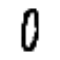

0
{'0': 0.866, '8': 0.083, '5': 0.024, '1': 0.012, '3': 0.004, '4': 0.003, '6': 0.003, '9': 0.003, '2': 0.001, '7': 0.001}
original:


preprocessed:


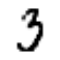

3
{'3': 0.988, '5': 0.007, '9': 0.003, '1': 0.001}
original:


preprocessed:


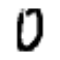

0
{'0': 0.998, '7': 0.001}
original:


preprocessed:


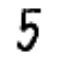

5
{'5': 0.748, '3': 0.244, '9': 0.005, '8': 0.002}
original:


preprocessed:


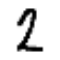

2
{'2': 0.978, '1': 0.019, '8': 0.002, '5': 0.001}
original:


preprocessed:


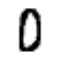

0
{'0': 0.99, '1': 0.007, '5': 0.001, '8': 0.001}
original:


preprocessed:


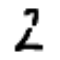

2
{'2': 1.0}
original:


preprocessed:


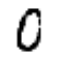

0
{'0': 0.975, '6': 0.014, '5': 0.01}


In [48]:
for img in [img for img in imgs if len(img)>0]:
    print ("=================================")
    print("original:")
    display(PIL.Image.fromarray(img))
    img = resize(thicken(img),28,4)
    # img = preprocess_img(img)
    print("preprocessed:")
    display(PIL.Image.fromarray(cv2.resize(img,(60,60))))
    predict(img)